## Time Series Analysis on MMASH Heart Rate Data

A few ideas for analysis:

1) register the heartbeat curves to sleep times to better capture the daily cycle of patients

2) correlate the heartbeat patterns to patients' cortisol level to get the effect of stress

3) correlate heartbeat with patients' activities such as steps per minute (although this may end up a bit trivial)

4) see what regularity of heartbeat can tell us about a patient's wellbeing

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import numpy
import scipy
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [3]:
from function_code import open_data, circadian, HRV_analysis

In [5]:
path = 'MMASH/DataPaper/' # Select the path where the data are allocated
users = os.listdir(path)[:-1] # Cerate a list of users' name

In [6]:
df_rr = open_data.create_dataset(users,'RR').reset_index() # Import dataset with RR intervals data

In [7]:
df_rr.head(15)

,user,ibi_s,day,time
0,user_1,0.258,1,10:10:17
1,user_1,0.319,1,10:10:18
2,user_1,0.266,1,10:10:18
3,user_1,0.401,1,10:10:18
4,user_1,1.089,1,10:10:19
5,user_1,0.752,1,10:10:20
6,user_1,0.337,1,10:10:20
7,user_1,0.933,1,10:10:21
8,user_1,0.731,1,10:10:22
9,user_1,0.454,1,10:10:23


### Plans for prelim processing

Example dataset got heartrate by diving 60 by heartbeat directly, which is think is not great for two reasons:

1) it does not follow medical convention of beats per minute

2) it results in super jittery data that's hard to smoothen afterwards

Here's my plan for prelim data processing:

1) the original data does not have time precision beyond the seconds level, which means the interval data (ibi_s) is the only thing we can rely upon, for precise heartbeat time

2) get heartrate by a moving average of of an one-minute window

3) get a rolling standard variation to account for heartbeat irregularity, e.g. ectopic beats

4) use timestamp as index to better employ the tools of time series

In [11]:
# change 'user_x' to "user_0x" for better plotting
df_rr["user"] = df_rr["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))

In [12]:
df_rr["user"] 

0          user_01
1          user_01
2          user_01
3          user_01
4          user_01
            ...   
1674040    user_08
1674041    user_08
1674042    user_08
1674043    user_08
1674044    user_08
Name: user, Length: 1674045, dtype: object

In [15]:
# Start denoting datetime
df_rr['date'] = ["2000-01-01 " if x == 1 else "2000-01-02 "
                        for x in df_rr['day']]
df_rr['datetime'] = pd.to_datetime(df_rr['date'] + df_rr['time'])
df_rr.tail()

,user,ibi_s,day,time,date,datetime
1674040,user_08,0.270,-29,09:08:08,2000-01-02,2000-01-02 09:08:08
1674041,user_08,0.325,-29,09:08:08,2000-01-02,2000-01-02 09:08:08
1674042,user_08,0.270,-29,09:08:08,2000-01-02,2000-01-02 09:08:08
1674043,user_08,0.300,-29,09:08:09,2000-01-02,2000-01-02 09:08:09
1674044,user_08,0.506,-29,09:08:09,2000-01-02,2000-01-02 09:08:09


In [57]:
# use datetime as index

df_res = df_rr.set_index(["datetime"])
df_res = df_res.drop(columns=["day", "date", "time"])


,user,ibi_s
datetime,,
2000-01-01 10:10:17,user_01,0.258
2000-01-01 10:10:18,user_01,0.319
2000-01-01 10:10:18,user_01,0.266
2000-01-01 10:10:18,user_01,0.401
2000-01-01 10:10:19,user_01,1.089


### Obtain BPM data

Ideally, the best way to get BPM is to count the # of measurements within a rolling 1-minute window

However, that hasn't been working out (I tried) because there are many missing measurements everywhere, which would result in artificially low BPM values

Instead, we just calculate BPM based on the average of the inverse of heartbeat intervals

So sad...

In [101]:
# there are multiple duplicate values in each datetime entry, which may create problems for the future
# the best thing to do now might be to get the bpm and standard deviation already so we'll no longer worry about duplicate values

# do NOT use resample because it's not the same thing!

df_tmp = pd.DataFrame()
df_tmp = df_res
df_tmp['bpm_s'] = 60 / df_tmp["ibi_s"]

#df_tmp = df_res.groupby("user").rolling('1T', min_periods=1).count()
#df_tmp = df_tmp.rename(columns={"ibi_s": "bpm"})

df_tmp = df_tmp.drop(columns=["hr", "ibi_s"])
df_tmp.head(200)

,user,bpm_s
datetime,,
2000-01-01 10:10:17,user_01,232.558140
2000-01-01 10:10:18,user_01,188.087774
2000-01-01 10:10:18,user_01,225.563910
2000-01-01 10:10:18,user_01,149.625935
2000-01-01 10:10:19,user_01,55.096419
...,...,...
2000-01-01 10:14:14,user_01,94.043887
2000-01-01 10:14:14,user_01,92.735703
2000-01-01 10:14:15,user_01,92.735703


In [161]:
# Get bmp per minute (resampled to 1 minute should make more sense than to 1 second)

df_bpm = df_tmp
df_bpm = df_bpm.groupby("user").resample("1s").mean()

df_bpm = df_bpm.reset_index("user")
df_bpm = df_bpm.groupby("user").resample("1t").mean()

df_bpm = df_bpm.rename(columns={"bpm_s": "bpm"})
df_bpm.head(200)

bpm
user    datetime                       
user_01 2000-01-01 10:10:00  121.334427
        2000-01-01 10:11:00  120.273937
        2000-01-01 10:12:00   98.493552
        2000-01-01 10:13:00   89.676134
        2000-01-01 10:14:00   92.679163
...                                 ...
        2000-01-01 13:25:00   71.765655
        2000-01-01 13:26:00   80.039895
        2000-01-01 13:27:00   83.380948
        2000-01-01 13:28:00   88.914090
        2000-01-01 13:29:00   91.457182

[200 rows x 1 columns]

In [162]:
# convert user from index to column names

df_bpm = df_bpm.reset_index("user")
df_bpm = df_bpm.pivot(columns='user')

In [163]:
# this multi-index is cancer and I seriously need to get rid of it
df_bpm.columns = df_bpm.columns.droplevel(0)

In [164]:
df_bpm.head(200)

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.547672,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.531326,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:07:00,NaN,NaN,NaN,61.043848,NaN,NaN,NaN,NaN,86.766466,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:08:00,NaN,NaN,NaN,77.759687,NaN,NaN,NaN,NaN,85.535371,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:09:00,NaN,NaN,NaN,76.321117,NaN,NaN,NaN,NaN,80.818694,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-01 12:20:00,73.977330,69.886424,73.090778,76.331485,80.025503,101.586180,90.119708,71.475977,62.100593,71.900787,...,87.722873,74.439211,85.489948,73.491613,103.852596,69.951559,101.581007,76.279722,79.466290,71.495074
2000-01-01 12:21:00,71.241037,75.645297,71.874475,70.985699,76.890894,101.508743,87.482731,80.048924,61.294001,74.433110,...,88.247630,74.959481,88.797117,75.097464,94.783065,66.664835,98.416037,74.004149,81.246607,68.005521
2000-01-01 12:22:00,75.425961,74.288331,72.496771,94.802971,75.874312,86.516719,95.664045,77.922017,62.321020,71.676111,...,86.478674,73.663940,89.613879,75.185851,103.532260,71.317157,99.038078,75.330909,87.838221,64.748884


In [165]:
df_bpm.describe().T

,count,mean,std,min,25%,50%,75%,max
user,,,,,,,,
user_01,1401.0,84.662401,16.362424,55.222482,70.586187,86.617951,96.849249,135.157189
user_02,1286.0,74.616041,15.616746,16.252393,68.005865,75.119627,82.281363,144.109039
user_03,1394.0,77.598589,17.824037,51.532017,62.836336,77.972438,84.502205,157.764712
user_04,1357.0,64.451716,9.271895,43.010464,56.837949,64.132307,71.258299,108.923767
user_05,1349.0,74.968961,11.725281,43.775371,66.483220,73.054675,82.304756,124.486047
user_06,1394.0,85.815096,14.795358,57.482219,71.479171,86.570595,96.228364,144.823854
user_07,1410.0,75.789277,14.586235,51.125177,62.975233,76.296046,85.904757,152.749945
user_08,1304.0,73.173968,13.433913,48.989645,63.156522,72.551917,80.737049,123.372034
user_10,1224.0,73.383585,10.860046,51.532466,66.119687,71.845360,79.287365,126.183591


In [90]:
# This is not finished! Definitely need to clean up the small values at the beginning and the end to get sane observations!

### Obtain rolling variation data

Getting the stardard deviation of the heatbeat interval may be helpful since it's indicate of one's heartbeat regularity

In [108]:
# Get the standard deviation

# I just realized it may be more helpful to get the std for heart rate, instead of heartbead interval, since it's more interpretable

df_tmp = pd.DataFrame()
df_tmp = df_res
df_tmp['bpm_s'] = 60 / df_tmp["ibi_s"]

df_tmp = df_tmp.drop(columns=["hr", "ibi_s"])
df_tmp.head(200)

,user,bpm_s
datetime,,
2000-01-01 10:10:17,user_01,232.558140
2000-01-01 10:10:18,user_01,188.087774
2000-01-01 10:10:18,user_01,225.563910
2000-01-01 10:10:18,user_01,149.625935
2000-01-01 10:10:19,user_01,55.096419
...,...,...
2000-01-01 10:14:14,user_01,94.043887
2000-01-01 10:14:14,user_01,92.735703
2000-01-01 10:14:15,user_01,92.735703


In [121]:
df_var = df_tmp
df_var = df_var.groupby("user").resample("1t").std()

df_var = df_var.rename(columns={"bpm_s": "var"})
df_var.head(200)

var
user    datetime                      
user_01 2000-01-01 10:10:00  72.861818
        2000-01-01 10:11:00  49.118777
        2000-01-01 10:12:00  36.679288
        2000-01-01 10:13:00   6.243889
        2000-01-01 10:14:00   5.984520
...                                ...
        2000-01-01 13:25:00   7.956103
        2000-01-01 13:26:00  13.021405
        2000-01-01 13:27:00   6.830799
        2000-01-01 13:28:00  26.451641
        2000-01-01 13:29:00   5.296888

[200 rows x 1 columns]

In [122]:
# convert user from index to column names

df_var = df_var.reset_index("user")
df_var = df_var.pivot(columns='user')

In [166]:

df_var.columns = df_var.columns.droplevel(0)

In [167]:
df_var.head(200)

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.086961,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.396340,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:07:00,NaN,NaN,NaN,30.192682,NaN,NaN,NaN,NaN,33.108720,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:08:00,NaN,NaN,NaN,31.855641,NaN,NaN,NaN,NaN,26.682052,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:09:00,NaN,NaN,NaN,24.147508,NaN,NaN,NaN,NaN,10.092503,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-01 12:20:00,10.602114,6.638806,7.399749,31.841968,6.735693,7.574818,6.248013,3.392512,14.084934,7.789006,...,5.469987,5.039873,6.316845,3.104670,5.923873,7.526386,13.758465,5.122456,5.882852,11.466332
2000-01-01 12:21:00,7.531983,38.143984,5.175779,18.315993,6.096483,10.273070,3.561329,6.606433,5.290418,6.577763,...,5.951418,7.780611,4.571560,2.188615,15.147013,7.324598,7.625137,4.807477,7.059165,9.002404
2000-01-01 12:22:00,8.225680,5.159243,5.581900,15.573148,6.256772,8.137051,7.705353,5.348769,5.967102,5.097857,...,4.591765,5.956286,20.526803,1.530888,13.616946,7.700252,5.842133,6.812260,6.539240,8.469232


### Visualizing data

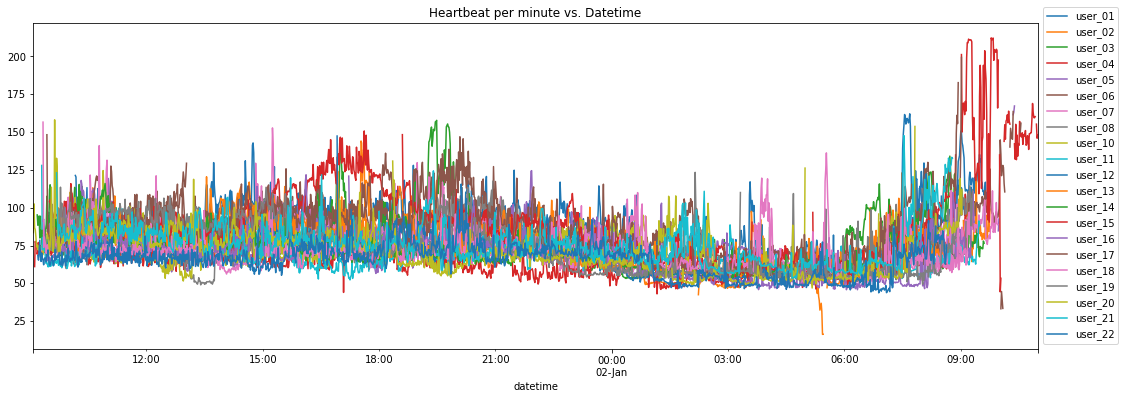

In [169]:
df_bpm.plot(legend='True', figsize=(18,6), title="Heartbeat per minute vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

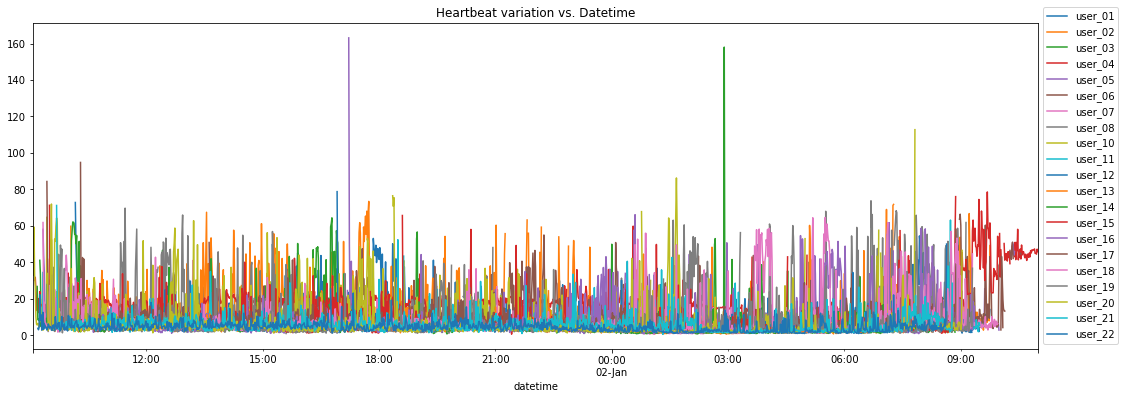

In [177]:
df_var.plot(legend='True', figsize=(18,6), title="Heartbeat variation vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

### Visualizing within one time slice

As we see, the big-picture plots were jittery. Can we get more insight from a timeslice?

It turns out that the BPM and the variation correspond pretty well

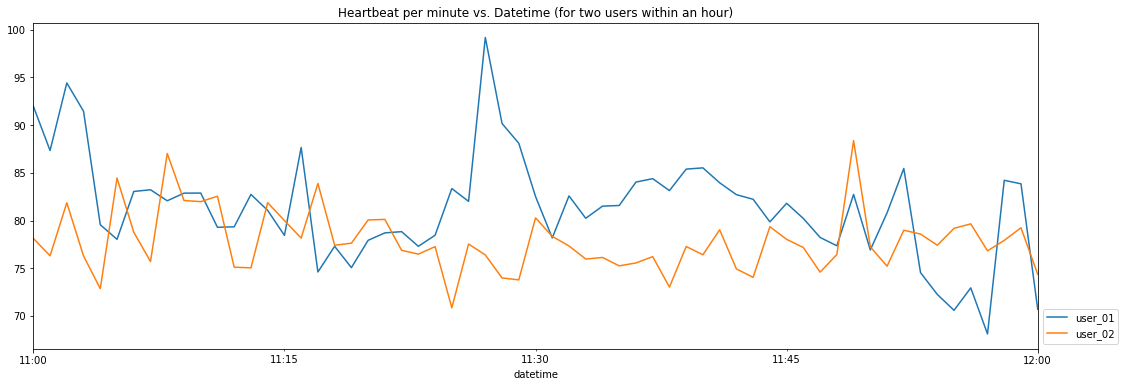

In [178]:
# Compare two users, within one hour
df_bpm["2000-01-01 11:00:00":"2000-01-01 12:00:00"][{"user_01", "user_02"}].plot(legend='True', figsize=(18,6), title="Heartbeat per minute vs. Datetime (for two users within an hour)");
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

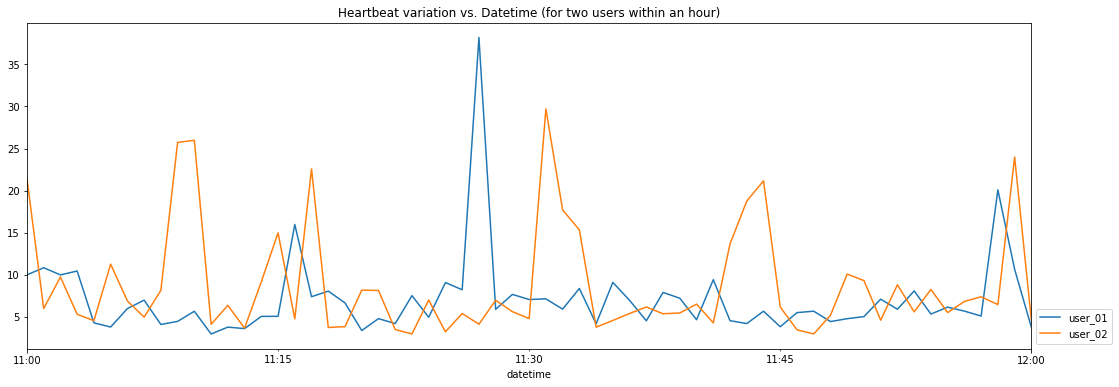

In [179]:
# Compare two users, within one hour
df_var["2000-01-01 11:00:00":"2000-01-01 12:00:00"][{"user_01", "user_02"}].plot(legend='True', figsize=(18,6), title="Heartbeat variation vs. Datetime (for two users within an hour)");
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

### Trimming low quality ends

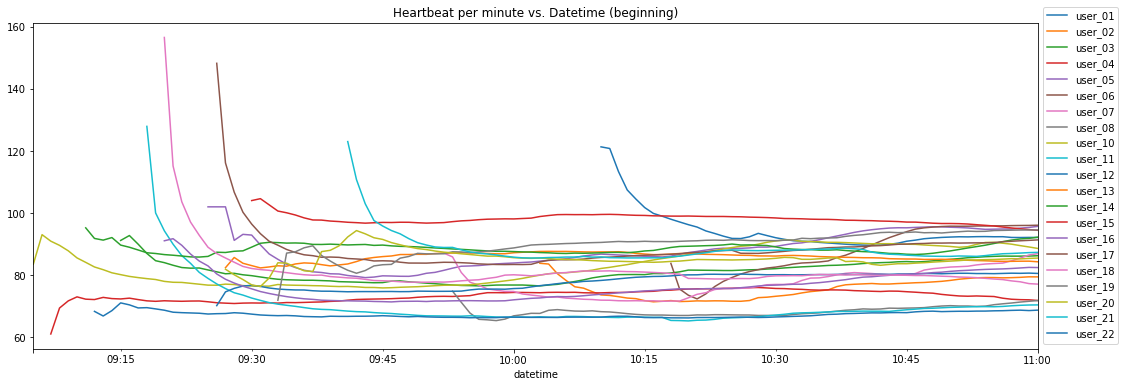

In [192]:
# Compare two users, within one hour

# Plotting as rolling just to see better the starting points of recording

df_bpm[:"2000-01-01 11:00:00"].rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Heartbeat per minute vs. Datetime (beginning)");
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

In [195]:
df_bpm["2000-01-01 10:30:00":].head()

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 10:30:00,78.168911,81.176301,83.678474,62.215047,105.627376,86.361680,80.541868,66.835199,98.357606,75.822056,...,78.468961,85.558998,96.683987,72.485099,95.219716,87.579896,88.528475,84.295792,90.790793,69.294222
2000-01-01 10:31:00,80.690521,80.909923,86.639614,67.371187,105.584814,88.753506,76.871011,66.866474,93.590284,77.625389,...,88.544335,83.271130,94.607001,73.295129,92.798513,79.643311,99.755394,92.479015,90.625121,67.381815
2000-01-01 10:32:00,81.216158,82.557659,82.569123,64.222883,99.624818,91.354992,85.534643,79.188054,72.388984,81.382383,...,87.382645,84.508487,96.705243,74.319443,92.996718,80.792977,94.949800,86.891393,88.536910,70.205764
2000-01-01 10:33:00,86.926529,89.786646,82.907445,62.796093,87.745598,88.776208,121.603142,77.328215,70.063922,70.988720,...,80.539282,81.685657,90.845621,68.181587,88.160509,74.202254,106.079680,81.538526,94.153046,70.277137
2000-01-01 10:34:00,88.685962,87.568920,83.329767,65.739318,101.123388,86.144061,110.039369,72.862542,67.211939,68.086883,...,74.825478,85.744934,90.915853,83.900744,92.228678,89.366483,94.240432,82.602722,91.597593,75.089101


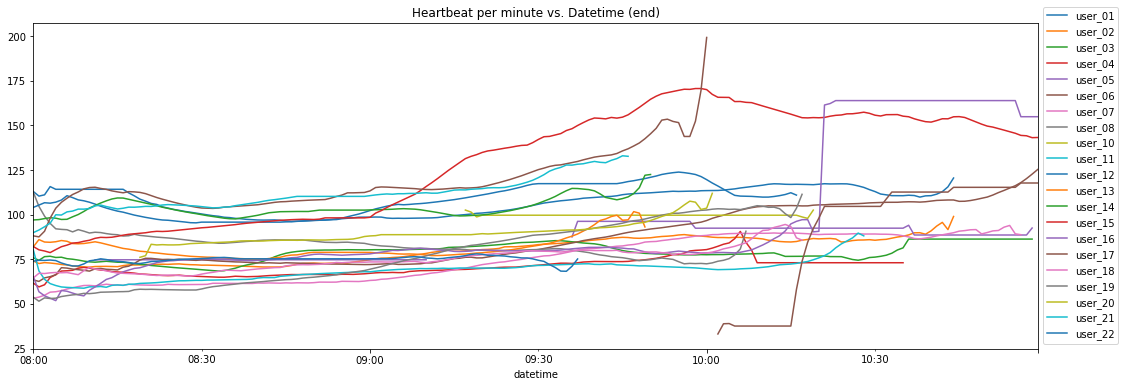

In [200]:
# Compare two users, within one hour

df_bpm["2000-01-02 08:00:00":].rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Heartbeat per minute vs. Datetime (end)");
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

In [205]:
df_bpm[: "2000-01-02 08:00:00"].tail()

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02 07:56:00,112.920060,70.724858,74.032391,62.394720,86.827974,64.314896,52.875306,70.014366,NaN,55.653198,...,84.891350,99.240382,77.643568,49.647149,94.388143,64.150605,52.767889,NaN,79.231518,72.913011
2000-01-02 07:57:00,111.335575,68.262087,72.140247,61.952747,NaN,70.051306,55.360630,70.936396,NaN,56.018246,...,86.232037,98.985562,78.460664,49.544242,91.401738,68.328285,52.859975,NaN,79.252297,69.458119
2000-01-02 07:58:00,115.425770,68.594655,71.613832,63.878715,NaN,60.995757,51.940261,71.698143,NaN,55.194364,...,88.464729,99.280288,79.230284,102.601468,97.059553,65.261270,56.816287,NaN,81.902342,70.819407
2000-01-02 07:59:00,123.974529,69.550551,71.701880,62.221626,NaN,65.485939,55.631339,93.772069,NaN,57.680379,...,83.856011,99.312545,77.175839,54.649459,101.980145,66.656127,56.677974,NaN,89.104454,72.726045
2000-01-02 08:00:00,112.993387,74.052281,75.886895,61.619344,NaN,63.460148,53.150894,112.568899,NaN,80.235712,...,82.012736,97.068345,82.152089,65.345530,88.142493,64.572914,53.733049,NaN,89.983771,73.957504


In [206]:
# Not the best cleaning ever but will do for the moment

df_bpm_cut = df_bpm["2000-01-01 10:30:00": "2000-01-02 09:00:00"]
df_var_cut = df_var["2000-01-01 10:30:00": "2000-01-02 09:00:00"]

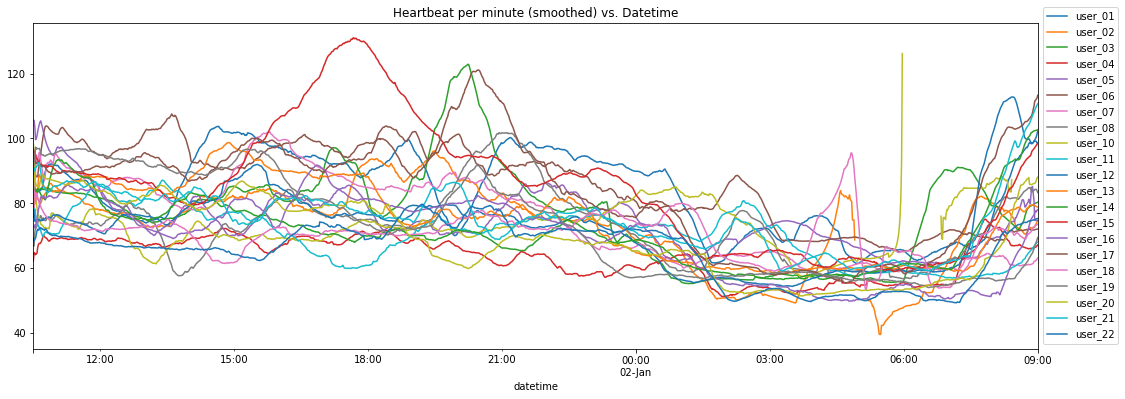

In [211]:
df_bpm_cut.rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Heartbeat per minute (smoothed) vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

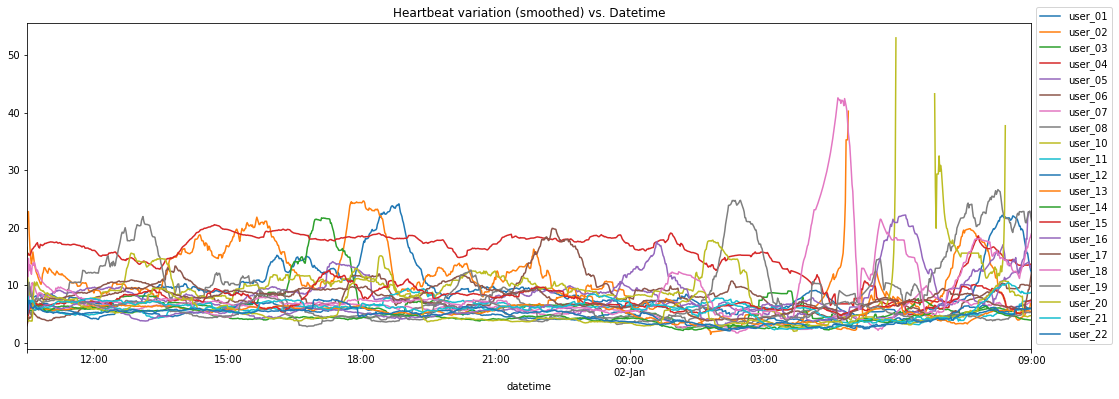

In [213]:
df_var_cut.rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Heartbeat variation (smoothed) vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

### BMP vs. Variation

Here's an example of two users. User 04 has lower BPM but higher BPM variation, while User 15 has higher BPM but lower variation. My initial guess from this is User 15 is more physically active (hence the BPM peak around 1800 hrs) and thus more physically fit (hence the lower variation); correlation with other data will be needed to confirm this hypothesis

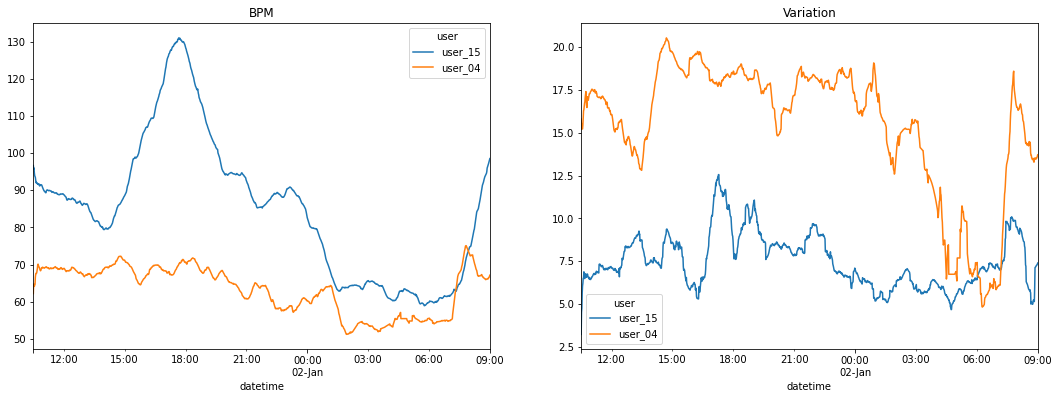

In [222]:
# overlay bpm and variation plots

fig, axes = plt.subplots(1,2);

ax1 = df_bpm_cut[{"user_04", "user_15"}].rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="BPM", ax=axes[0])
ax2 = df_var_cut[{"user_04", "user_15"}].rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Variation", ax=axes[1])
plt.show()

In [244]:
# First let's check if the high variation of User 04 makes any sense by taking a look at the original data

df_res[df_res["user"]=="user_04"]["2000-01-01 11:00:00":"2000-01-01 12:00:00"][{"ibi_s", "hr"}].head(30)

,hr,ibi_s
datetime,,
2000-01-01 11:00:00,68.649886,0.874
2000-01-01 11:00:01,70.671378,0.849
2000-01-01 11:00:02,37.014189,1.621
2000-01-01 11:00:03,79.681275,0.753
2000-01-01 11:00:05,41.180508,1.457
2000-01-01 11:00:05,87.209302,0.688
2000-01-01 11:00:06,82.872928,0.724
2000-01-01 11:00:07,76.530612,0.784
2000-01-01 11:00:08,38.809832,1.546


### Getting user info

Looks like (pobrecito) user 04 skip one heartbeat every several beats.

1) We need to make sure first if it were actually the case or just faulty device

2) basic bio data shows that user 04 and 15 are very comparable in age and weight, a good condition for our study

3）according to the plot, the variation of user 04 gets much lower toward the end of his sleep; let's take a look at sleep data

In [231]:
# Get basic bio info

df_antro = open_data.create_dataset(users,'user_info') # Import dataset with antropometric characteristics
df_antro = df_antro.reset_index()
df_antro["user"] = df_antro["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_antro = df_antro.sort_values("user", ascending=True)
df_antro.set_index("user", inplace=True)
df_antro

,Gender,Weight,Height,Age
user,,,,
user_01,M,65,169,29.0
user_02,M,95,183,27.0
user_03,M,70,174,34.0
user_04,M,76,180,27.0
user_05,M,80,196,25.0
user_06,M,62,178,27.0
user_07,M,65,183,25.0
user_08,M,74,184,40.0
user_10,M,85,180,27.0


### Questionnaire Data

questionnaire.csv - scores for all the questionnaires:

MEQ: Morningness-Eveningness Questionnaire value. The chronotype score is ranging from 16 to 86: scores of 41 and below indicate Evening types, scores of 59 and above indicate Morning types, scores between 42-58 indicate intermediate types [1].

STAI1: State Anxiety value obtained from State-Trait Anxiety Inventory. The results are range from 20 to 80. Scores less than 31 may indicate low or no anxiety, scores between 31 and 49 an average level of anxiety or borderline levels, and scores higher than 50 a high level of anxiety or positive test results [2].

STAI2: Trait Anxiety value obtained from the State-Trait Anxiety Inventory. The results are range from 20 to 80. Scores less than 31 may indicate low or no anxiety, scores between 31 and 49 an average level of anxiety or borderline levels, and scores higher than 50 a high level of anxiety or positive test results [2].

PSQI: Pittsburgh Sleep Quality Questionnaire Index. It gives a score rating from 0 to 21, with values lower than 6 indicating good sleep quality [3].

BIS/BAS: Behavioural avoidance/inhibition index [4]. BIS/BAS scales are a typical measure of reinforcement sensitivity theory that establish biological roots in personality characteristics, derived from neuropsychological differences. The BIS/BAS scales comprise a self‐report measure of avoidance and approach tendencies that contains four sub-factors (A high score in one of the subscale describes the degree of that temperamental characteristic for the individual, according to the original sample):

Bis facet reflects subject sensitivity toward aversive events that promote avoidance behaviours.

Drive describes individual persistence and motivational intensity.

Reward corresponds to Reward Responsiveness that indicates a propensity to show a higher degree of positive emotion for goal attainment.

Fun corresponds to Fun-Seeking that is related to impulsivity and immediate reward due to sensory stimuli or risky situations.

Daily_stress: Daily Stress Inventory value (DSI) is a 58 items self-reported measures which allows a person to indicate the events they experienced in the last 24 hours. After indicating which event occurred, they indicate the stressfulness of the invent on a Likert scale from 1 (occurred but was not stressful) to 7 (Cause me to panic). It gives a score between 0 and 406. The higher is this values, the higher is the frequency and degree of the events and the perceived daily stress [5].

PANAS: Positive and Negative Affect Schedule. It gives a score rating between 5 and 50 for both positive and negative emotions [6]. The higher is the PANAS value, the higher is the perceived emotion. Columns name with 10, 14, 22 and 9+1 refer to the time of the day when the questionnaire is filled in. 9+1 indicates the 9 AM of the second recording day.

In [251]:
# take a look at the questionnaire in case of anxiety

df_question = open_data.create_dataset(users,'questionnaire') # Import dataset with questionnaire data
df_question = df_question.reset_index()
df_question["user"] = df_question["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_question = df_question.sort_values("user", ascending=True)
df_question.set_index("user", inplace=True)
df_question

,MEQ,STAI1,STAI2,Pittsburgh,Daily_stress,BISBAS_bis,BISBAS_reward,BISBAS_drive,BISBAS_fun,panas_pos_10,panas_pos_14,panas_pos_18,panas_pos_22,panas_pos_9+1,panas_neg_10,panas_neg_14,panas_neg_18,panas_neg_22,panas_neg_9+1
user,,,,,,,,,,,,,,,,,,,
user_01,47.0,41.0,43.0,5.0,23.0,22.0,21.0,14.0,14.0,21.0,17.0,12.0,18.0,17.0,11.0,13.0,13.0,10.0,10.0
user_02,52.0,24.0,39.0,7.0,26.0,26.0,21.0,12.0,6.0,37.0,32.0,24.0,27.0,33.0,11.0,10.0,16.0,17.0,18.0
user_03,59.0,27.0,27.0,8.0,11.0,19.0,18.0,12.0,6.0,35.0,34.0,31.0,28.0,35.0,11.0,12.0,11.0,12.0,11.0
user_04,60.0,28.0,40.0,4.0,10.0,20.0,17.0,13.0,14.0,30.0,27.0,22.0,19.0,26.0,11.0,13.0,15.0,14.0,14.0
user_05,52.0,54.0,47.0,8.0,41.0,25.0,23.0,14.0,15.0,30.0,25.0,31.0,27.0,31.0,26.0,17.0,17.0,15.0,16.0
user_06,48.0,32.0,47.0,9.0,41.0,19.0,19.0,13.0,15.0,27.0,25.0,30.0,25.0,14.0,13.0,12.0,13.0,15.0,16.0
user_07,46.0,33.0,NaN,7.0,69.0,19.0,19.0,12.0,6.0,22.0,13.0,13.0,11.0,13.0,11.0,13.0,16.0,14.0,13.0
user_08,64.0,32.0,39.0,3.0,74.0,24.0,18.0,12.0,9.0,36.0,25.0,30.0,21.0,24.0,14.0,11.0,10.0,12.0,10.0
user_10,38.0,39.0,46.0,4.0,14.0,19.0,16.0,16.0,14.0,28.0,23.0,21.0,18.0,23.0,15.0,23.0,23.0,27.0,12.0


In [257]:
df_show = df_question.loc[{"user_04", "user_15"}].sort_index().T
df_show["diff"] = abs(np.log(df_show["user_04"] / df_show["user_15"])).round(1)

In [258]:
df_show

user,user_04,user_15,diff
MEQ,60.0,58.0,0.0
STAI1,28.0,52.0,0.6
STAI2,40.0,42.0,0.0
Pittsburgh,4.0,5.0,0.2
Daily_stress,10.0,35.0,1.3
BISBAS_bis,20.0,25.0,0.2
BISBAS_reward,17.0,25.0,0.4
BISBAS_drive,13.0,16.0,0.2
BISBAS_fun,14.0,16.0,0.1
panas_pos_10,30.0,28.0,0.1


**User 15 suffers from much higher stress than User 04, but also seem to be a little bit more rewarding**

Btw, the activity at 1800 hrs conducted by User 15 (whatever may it be) seems to induce very high both position and negative emotions (from panas question)

### Sleep Data

sleep.csv - information about sleep duration and sleep quality of the participant:

In Bed Date: 1 and 2 refer to the first and second day of data recording, respectively.

In Bed Time: time of the day (hours:minutes) when the user went to the bed.

Out Bed Date: 1 and 2 refer to the first and second day of data recording, respectively.

Out Bed Time: time of the day (hours:minutes) when the user went out of the bed.

Onset Date: 1 and 2 refer to the first and second day of data recording, respectively.

Onset Time: time of the day (hours:minutes) when the user falls asleep.

Latency Efficiency: percentage of sleep time on total sleep in bed.

Total Minutes in Bed: minutes spent in the bed per night.

Total Sleep Time (TST): length of the sleep per night expressed in minutes.

Wake After Sleep Onset (WASO): time spent awake after falling asleep the first time.

Number of Awakenings during the night

Average Awakening Length: time in seconds spent awakening during the night.

Movement Index: number of minutes without movement expressed as a percentage of the movement phase (i.e., number of period with arm movement).

Fragmentation Index: number of minutes with movement expressed as a percentage of the immobile phase (i.e., the number of period without arm movement).

Sleep Fragmentation Index: ratio between the Movement and Fragmentation indices.


In [259]:
df_sleep = open_data.create_dataset(users,'sleep') # Import dataset with questionnaire data
df_sleep = df_sleep.reset_index()
df_sleep["user"] = df_sleep["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_sleep = df_sleep.sort_values("user", ascending=True)
df_sleep.set_index("user", inplace=True)
df_sleep

,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
user,,,,,,,,,,,,,,,,
user_01,2,00:46,2,03:31,2,00:46,NaN,87.27,165,144,21,9,2.33,9.091,10.000,19.091
user_01,2,03:57,2,07:30,2,03:57,NaN,92.02,213,196,17,9,1.89,8.920,NaN,8.920
user_02,2,00:50,2,06:22,2,00:54,4.0,73.49,332,244,84,18,4.67,15.060,5.556,20.616
user_03,1,22:29,1,05:52,1,22:32,3.0,79.23,443,351,89,16,5.56,18.962,NaN,18.962
user_04,2,00:57,2,07:10,2,01:01,4.0,85.52,373,319,50,28,1.79,8.847,14.286,23.133
user_05,1,23:56,1,06:42,1,23:56,NaN,85.71,406,348,58,21,2.76,11.576,9.524,21.100
user_06,2,02:27,2,09:02,2,02:27,NaN,84.30,395,333,62,20,3.10,10.633,4.762,15.395
user_07,2,00:28,2,08:02,2,00:28,NaN,75.33,454,342,112,31,3.61,17.401,28.125,45.526
user_08,2,00:17,2,07:13,2,00:20,3.0,80.77,416,336,77,27,2.85,17.308,25.926,43.234


In [262]:
df_show = df_sleep.loc[{"user_04", "user_15"}].sort_index().T
df_show

user,user_04,user_15
In Bed Date,2,2
In Bed Time,00:57,01:15
Out Bed Date,2,2
Out Bed Time,07:10,05:39
Onset Date,2,2
Onset Time,01:01,01:16
Latency,4.0,1.0
Efficiency,85.52,89.39
Total Minutes in Bed,373,264
Total Sleep Time (TST),319,236


### Activity Data

Activity.csv - list of the activity categories throughout the day. The categories are (the activities listed below correspond to the numeric ID of each activity in the csv file):
1. sleeping.
2. laying down.
3. sitting, e.g. studying, eating and driving.
4. light movement, e.g. slow/medium walk, chores and work.
5. medium, e.g. fast walk and bike.
6. heavy, e.g. gym, running.
7. eating.
8. small screen usage, e.g. smartphone and computer.
9. large screen usage, e.g. TV and cinema.
10. caffeinated drink consumption, e.g. coffee or coke.
11. smoking.
12 alcohol assumption. 'Start' and 'end' columns refer to the time of the day (hours:minutes) when the event happened, while 'day' columns refers to the day when it happened (1 and 2 refer to the first and second day of data recording, respectively).

In [268]:
df_activity = open_data.create_dataset(users,'Activity',replace_na=False) # Import dataset with Activity diary data

# Create dict to map activity reported by users in the activity diary
dict_activity = {0: 'sleeping',
                 1: 'laying down',
                 2: 'sitting',
                 3: 'light movement',
                 4: 'medium movement',
                 5: 'heavy movement',
                 6: 'eating',
                 7: 'small screen usage',
                 8: 'large screen',
                 9: 'coffee/coke',
                 10: 'smoking',
                 11: 'alcohol assumption',
                 12: 'saliva samples'}

df_activity['Activity'] = df_activity['Activity'].replace(dict_activity) # maping activity

In [276]:
df_activity = df_activity.reset_index()
df_activity["user"] = df_activity["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_activity = df_activity.sort_values(["user", "Day", "Start"], ascending=True)
df_activity.set_index("user", inplace=True)

df_activity

,Activity,Start,End,Day
user,,,,
user_01,sitting,10:00,10:22,1
user_01,coffee/coke,10:37,10:40,1
user_01,smoking,10:40,10:45,1
user_01,eating,10:55,11:00,1
user_01,sitting,11:00,11:20,1
...,...,...,...,...
user_22,eating,21:00,21:40,1
user_22,light movement,22:30,00:10,1
user_22,alcohol assumption,23:20,23:30,1


In [279]:
df_show = df_activity.loc[{"user_04", "user_15"}]
df_show

,Activity,Start,End,Day
user,,,,
user_15,eating,07:30,07:40,1
user_15,light movement,10:00,13:00,1
user_15,eating,13:30,14:00,1
user_15,coffee/coke,13:30,14:00,1
user_15,light movement,15:00,18:00,1
user_15,heavy movement,19:00,21:00,1
user_15,eating,22:00,22:30,1
user_15,saliva samples,22:00,22:10,1
user_15,sleeping,22:30,07:30,1


**User 04 (high variation) lives a rather sedentary life with lots of phone usages, while User 15 is very active (seems to have work with lots of light movement and also works out (with heavy movement）**

The sleep time reported by User 15 contradicts the time shown in the sleep data!

### Saliva Data

saliva.csv - clock genes and hormones concentrations in the saliva before going to bed and after waking up. 

Two samples per participant are included, one before sleep and one after waking up, as indicated by the "Sample" data column. 

Melatonin levels are reported in μg of melatonin per μg of protein, while cortisol levels are in μg of cortisol per 100 μg of protein. 

No clock genes and hormones concentrations data was provided for User_21 due to problem in the salivary samples that do not permit to analyse it.

In [288]:
df_saliva = open_data.create_dataset(users,'saliva') # Import dataset with saliva data\

NO data for user_21


In [290]:
df_saliva = df_saliva.reset_index()
df_saliva["user"] = df_saliva["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_saliva = df_saliva.sort_values(["user", "SAMPLES"], ascending=True)
df_saliva.set_index("user", inplace=True)
#df_saliva = df_saliva.drop(columns=["index"])

#df_saliva

In [307]:
df_show = df_saliva.loc[{"user_04", "user_15"}]
df_show

,SAMPLES,Cortisol NORM,Melatonin NORM
user,,,
user_15,before sleep,0.020579,2.607041e-09
user_15,wake up,0.042939,1.194220e-09
user_04,before sleep,0.023772,2.149747e-08
user_04,wake up,0.041724,8.055610e-09


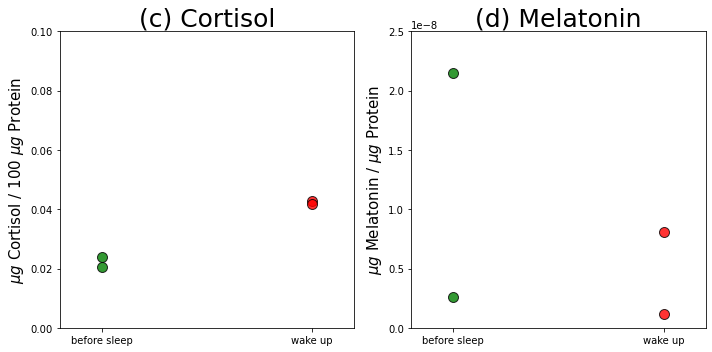

In [308]:
# Line plot of Cortisol and Melatonin concentrations obtained from saliva sample. Differencebetween “before sleep” and “wake up” hormones concentration

f,ax = plt.subplots(1,2,figsize=(10,5))
for w,c in zip(['before sleep','wake up'],['g','r']):
    df_w = df_show[df_show['SAMPLES']==w]
    df_w = df_w[df_w['Cortisol NORM']<0.1]
    ax[0].scatter([w]*len(df_w), df_w['Cortisol NORM'], c=c, label=w, edgecolors='k', s=100, alpha=0.8)
ax[0].set_title('(c) Cortisol',fontsize=25)
ax[0].set_ylabel('$\mu g$ Cortisol / 100 $\mu g$ Protein',fontsize=15)
ax[0].set_xlabel('')
plt.sca(ax[0])
plt.xlim(-0.2,1.2)
plt.ylim(0,0.10)

for w,c in zip(['before sleep','wake up'],['g','r']):
    df_w = df_show[df_show['SAMPLES']==w]
    df_w = df_w[df_w['Melatonin NORM']<2.5e-8]
    ax[1].scatter([w]*len(df_w), df_w['Melatonin NORM'], c=c, edgecolors='k', s=100, alpha=0.8)
ax[1].set_title('(d) Melatonin',fontsize=25)
ax[1].set_ylabel('$\mu g$ Melatonin / $\mu g$ Protein',fontsize=15)
ax[1].set_xlabel('')
plt.sca(ax[1])
plt.xlim(-0.2,1.2)
plt.ylim(0,2.5e-8)

f.tight_layout()
plt.show()

**User 04 (high variation)'s Melatonin level is a lot higher than User 05 (high BPM)'s, especially before sleep**, that's why he was able to fall asleep much sooner.

Remarkably, cortisol levels are about the same, despite the obviou difference in lifestyle and stress level. There are two possibilities:

1) cortisol level is not really indicative of stress, or

2) just two measurements before sleep and wake up is not reliable

I would rather go with 2)

### ""Fitbit"" Data

Actigraph.csv - accelerometer and inclinometer data recorded throughout the day:

Axis1: Raw Acceleration data of the X-axis expressed in Newton-meter.

Axis2: Raw Acceleration data of the Y-axis expressed in Newton-meter.

Axis3: Raw Acceleration data of the Z-axis expressed in Newton-meter.

Steps: number of steps per second.

HR: beats per minutes (bpm).

Inclinometer Off: values equal to 1 refer to no activation of the inclinometer. The values are reported per second.

Inclinometer Standing: values equal to 1 refer to the standing position of the user, while 0 refers to other user positions. Values are reported per second.

Inclinometer Sitting: values equal to 1 refer to the sitting position of the user, while 0 refers to other user positions. Values are reported per second.

Inclinometer Lying: values equal to 1 refer to the lying position of the user, while 0 refers to other user positions. Values are reported per second.

Vector Magnitude: vector movement derived from raw acceleration data expressed in Newton-meter.
day: 1 and 2 refer to the first and second day of data recording, respectively.

time: day time when the heartbeat happened (hours:minutes:seconds)

In [313]:
df_actigraph0 = open_data.create_dataset(users,'Actigraph') # Import dataset with actigraph data

In [316]:
df_show = df_actigraph0.loc[{"user_4", "user_15"}].T
df_show

user,user_4,user_4,user_4,user_4,user_4,user_4,user_4,user_4,user_4,user_4,...,user_15,user_15,user_15,user_15,user_15,user_15,user_15,user_15,user_15,user_15
Axis1,77.0,65.0,78.0,138.0,36.0,77.0,185.0,99.0,10.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axis2,140.0,137.0,51.0,198.0,50.0,196.0,180.0,116.0,51.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axis3,64.0,48.0,34.0,21.0,21.0,80.0,137.0,64.0,26.0,140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steps,1.0,1.0,2.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HR,71.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,81.0,...,141.0,141.0,141.0,141.0,144.0,145.0,145.0,146.0,152.0,157.0
Inclinometer Off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Inclinometer Standing,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inclinometer Sitting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inclinometer Lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vector Magnitude,172.12,159.05,99.2,242.26,65.09,225.27,292.22,165.39,58.11,199.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**the most useful data here should be steps and heartrate**

We already have one heartrate we extracted, but it would be helpful to compare

as for steps, it could be indicative of any workout activities

In [325]:
# again, make the user number better

df_actigraph = df_actigraph0.reset_index()
df_actigraph["user"] = df_actigraph["user"].apply(lambda x: "user_" + x.strip("user_").zfill(2))
df_actigraph = df_actigraph.sort_values(["user"], ascending=True)

# change to time series

# Start denoting datetime
df_actigraph['date'] = ["2000-01-01 " if x == 1 else "2000-01-02 "
                        for x in df_actigraph['day']]
df_actigraph['datetime'] = pd.to_datetime(df_rr['date'] + df_rr['time'])
df_actigraph.tail()

# use datetime as index

df_actigraph = df_actigraph.set_index(["datetime"])
df_actigraph = df_actigraph.sort_index()
df_actigraph = df_actigraph.drop(columns=["day", "date", "time"])

In [334]:
df_actigraph[df_actigraph["user"] == "user_15"]["2000-01-01 18:00:00": "2000-01-01 18:30:00"]

,user,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude
datetime,,,,,,,,,,,
2000-01-01 18:00:04,user_15,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,1.0,NaN
2000-01-01 18:00:05,user_15,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,1.0,NaN
2000-01-01 18:00:06,user_15,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,1.0,NaN
2000-01-01 18:00:07,user_15,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,1.0,NaN
2000-01-01 18:00:08,user_15,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2000-01-01 18:29:56,user_15,146.0,238.0,105.0,1.0,99.0,NaN,1.0,NaN,NaN,298.30
2000-01-01 18:29:57,user_15,40.0,194.0,74.0,NaN,97.0,NaN,1.0,NaN,NaN,211.45
2000-01-01 18:29:58,user_15,58.0,54.0,81.0,NaN,95.0,NaN,1.0,NaN,NaN,113.32


<AxesSubplot:xlabel='datetime'>

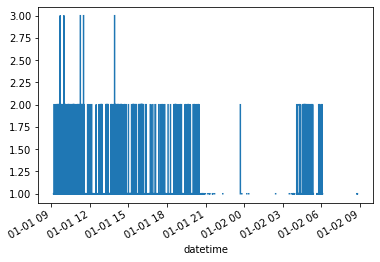

In [338]:
df_actigraph[df_actigraph["user"] == "user_15"]["Steps"].plot()

**So, steps data end up being useless because** 1) only users 15 (high heartrate) recorded it, and 2) it's step per second, and it's stored as integer, so, totally useless 

(whom exactly did this piece of art???)

<AxesSubplot:xlabel='datetime'>

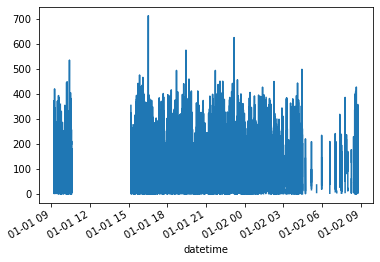

In [341]:
df_actigraph[{}]["Vector Magnitude"].plot()

In [351]:
# Get bmp per minute (resampled to 1 minute should make more sense than to 1 second)

df_act_bpm = df_actigraph[{"user", "HR"}]

#df_act_bpm = df_act_bpm.reset_index("user")
df_act_bpm = df_act_bpm.groupby("user").resample("1t").mean()

df_act_bpm.head(200)

HR
user    datetime                       
user_01 2000-01-01 10:10:00  112.840000
        2000-01-01 10:11:00  130.411765
        2000-01-01 10:12:00   94.142857
        2000-01-01 10:13:00   91.402778
        2000-01-01 10:14:00   89.000000
...                                 ...
        2000-01-01 13:25:00  102.981818
        2000-01-01 13:26:00  107.029851
        2000-01-01 13:27:00  109.323529
        2000-01-01 13:28:00  108.411765
        2000-01-01 13:29:00  109.478261

[200 rows x 1 columns]

In [353]:
# convert user from index to column names

df_act_bpm = df_act_bpm.reset_index("user")
df_act_bpm = df_act_bpm.pivot(columns='user')

df_act_bpm.columns = df_act_bpm.columns.droplevel(0)

In [354]:
df_act_bpm

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.961538,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.805556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:07:00,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,71.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:08:00,NaN,NaN,NaN,NaN,NaN,NaN,97.216216,NaN,72.265625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:09:00,NaN,NaN,NaN,NaN,NaN,NaN,95.735849,NaN,71.739130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-02 10:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,74.200000,NaN,NaN,NaN,NaN,NaN
2000-01-02 10:56:00,NaN,67.885246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,58.102041,NaN,NaN,NaN,NaN
2000-01-02 10:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,74.567797,NaN,NaN,NaN,NaN,NaN


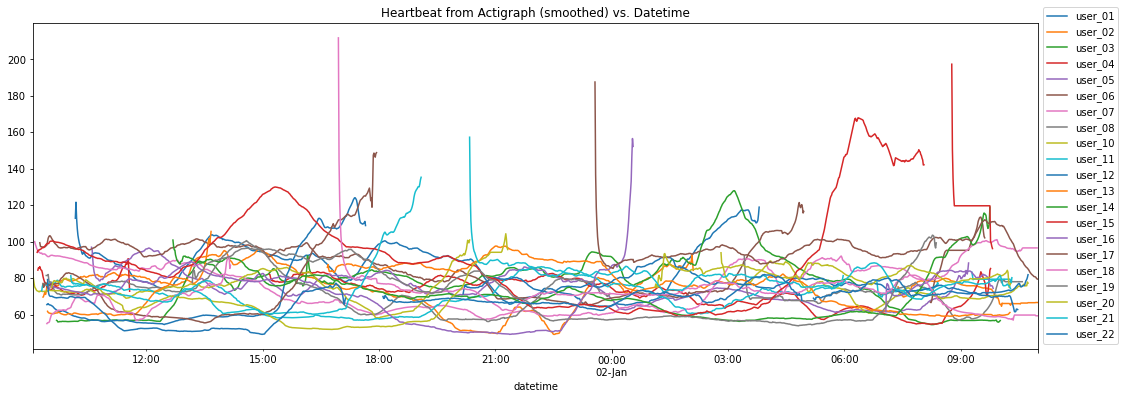

In [355]:
df_act_bpm.rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Heartbeat from Actigraph (smoothed) vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

**Data quality looks super low. Not a fan**

In [357]:
 # Get acceleration (vector magnitude) per minute (resampled to 1 minute should make more sense than to 1 second)

df_act_vec = df_actigraph[{"user", "Vector Magnitude"}]

#df_act_bpm = df_act_bpm.reset_index("user")
df_act_vec = df_act_vec.groupby("user").resample("1t").mean()

df_act_vec.head(200)

# convert user from index to column names

df_act_vec = df_act_vec.reset_index("user")
df_act_vec = df_act_vec.pivot(columns='user')

df_act_vec.columns = df_act_vec.columns.droplevel(0)

In [358]:
df_act_vec

user,user_01,user_02,user_03,user_04,user_05,user_06,user_07,user_08,user_10,user_11,...,user_13,user_14,user_15,user_16,user_17,user_18,user_19,user_20,user_21,user_22
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.685556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.674231,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:07:00,NaN,NaN,NaN,NaN,NaN,NaN,36.606250,NaN,68.288421,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:08:00,NaN,NaN,NaN,NaN,NaN,NaN,68.973939,NaN,89.925246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 09:09:00,NaN,NaN,NaN,NaN,NaN,NaN,50.477297,NaN,115.917015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-02 10:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,32.392500,NaN,NaN,NaN,NaN,NaN
2000-01-02 10:56:00,NaN,68.688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,65.903333,NaN,NaN,NaN,NaN
2000-01-02 10:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


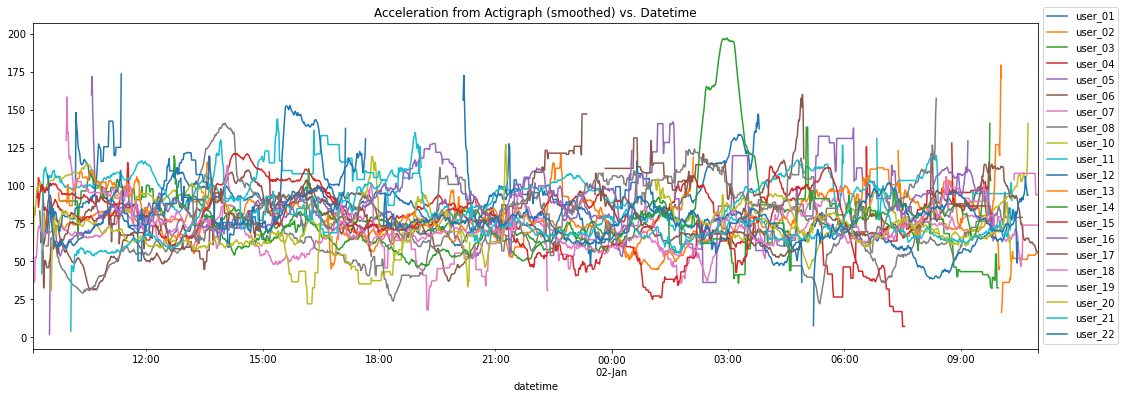

In [360]:
df_act_vec.rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Acceleration from Actigraph (smoothed) vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

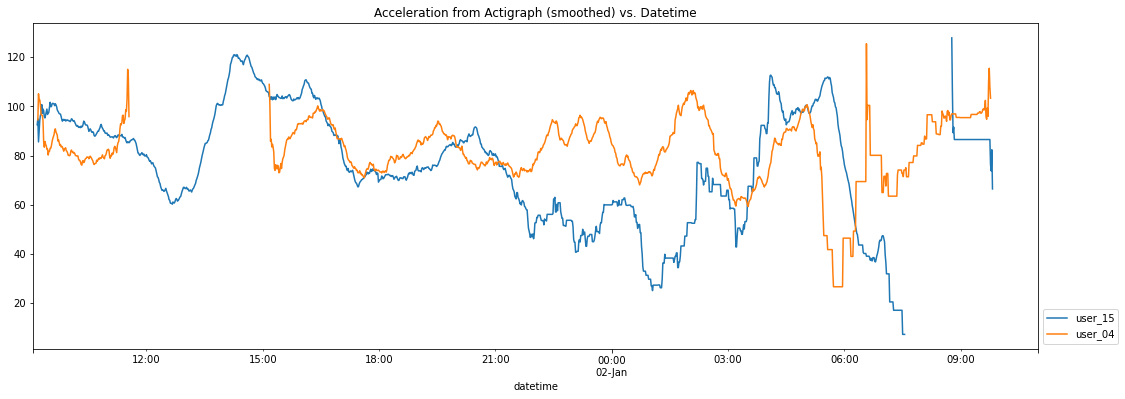

In [362]:
df_act_vec[{"user_04", "user_15"}].rolling('1H', min_periods=1).mean().plot(legend='True', figsize=(18,6), title="Acceleration from Actigraph (smoothed) vs. Datetime");

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

#["2000-01-01 11:00:00":"2000-01-01 12:00:00"]



**Nah, I'm guessing this acceleration is not really indicative of workout. Fail.**

It seems we can conclude that the actigraph data are by and large useless

## Starting Functional Analysis

Now we have (reasonably) clean data, we can start employing FDA methods to draw some further insights.

Here are some potential steps:

1) Cut the datasets into a common interval and convert into functional data

2) Find the best basis function to approximate the functional data

3) Unsupervised learning to classify the patients into a few categories

4) Define several categories "manually" according to other data (high stress/low stress; good sleep/bad sleep; active/sedentary)

5) Supervised training to connect the functional data to the categories 